<a href="https://colab.research.google.com/github/AchrafAsh/best-istanbul-datathon/blob/main/istanbul_datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

### Processing of the provider dataframes

In [6]:
# dataset paths
path_provider_1 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider1_Usecase2.csv"
path_provider_2 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider2_Usecase2.csv"
path_provider_3 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider3_Usecase2.csv"
path_generation = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"

In [7]:
# format date
def format_date(date:int):
    date_string = str(date)
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    # convert to datetime
    return f"{year}-{month}-{day}"

In [8]:
def get_provider_data(path: str):
    df_provider = pd.read_csv(path, sep=";")
    # change column names
    df_provider.rename(columns={ "Datekey": "date",
                                "ProviderId": "provider_id",
                                "Hour": "hour",
                                "WindSpeed": "wind_speed",
                                "WindDirection": "wind_direction",
                                "Temperature": "temperature",
                                "Pressure": "pressure",
                                "Humidity": "humidity",
                                "PowerWOAvailability": "power"},
                        inplace=True)
    # format date
    df_provider["date"] = df_provider["date"].apply(format_date)
    # aggregate date and hour
    df_provider["date"] = df_provider["date"] + "T" + df_provider["hour"]
    # convert to datetime object
    df_provider["date"] = df_provider.date.apply(
        lambda d: datetime.strptime(d,"%Y-%m-%dT%H:%M")
        )
    # drop hour column
    df_provider.drop(columns=["hour"], inplace=True)
    return df_provider

In [9]:
provider_1 = get_provider_data(path_provider_1)
provider_2 = get_provider_data(path_provider_2)
provider_3 = get_provider_data(path_provider_3)

In [10]:
'''
averaging_function 

input :
- list of dataframes (provider_i for i in 1,2,3)

returns :
- unique dataframe with same columns, no nans, average of meteo and power data
'''

def average_forecasts(list_of_providers):
    
    # Meteorological data 
    
    provider_1 = list_of_providers[0]
    provider_2 = list_of_providers[1]
    provider_3 = list_of_providers[2]
    
    provider_final_df = pd.DataFrame(index = list(provider_1.index), columns = list(provider_1.columns))
    
    provider_final_df.date = provider_1.date
    
    del provider_final_df['provider_id']
    
    for column in list(provider_final_df.columns):
        
        if column != 'date':
        
            to_average = pd.DataFrame() 
            to_average[column+'_1'] = provider_1[column]
            to_average[column+'_2'] = provider_2[column]
            to_average[column+'_3'] = provider_3[column]

            provider_final_df[column] = to_average.mean(axis = 1)
    
    return(provider_final_df)

In [11]:
average_provider = average_forecasts([provider_1, provider_2, provider_3])

In [ ]:
### Processing of the Actual generation dataframe

In [12]:
actual_generation = pd.read_csv(path_generation, sep=";", parse_dates=["PCTimeStamp"])
actual_generation.rename(columns={"PCTimeStamp": "date",
                                  "PowerMWh": "power"},
                         inplace=True)

### Visualization

[Text(0.5, 1.0, 'Forecasted and actual production (7 days)')]

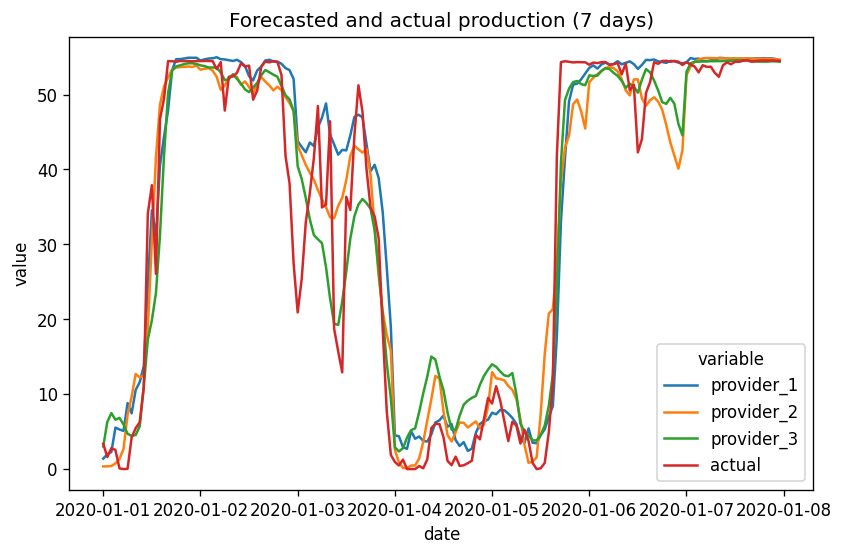

In [13]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "provider_1": provider_1[:168]["power"],
    "provider_2": provider_2[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Forecasted and actual production (7 days)")

[Text(0.5, 1.0, 'Average forecasted and actual production (7 days)')]

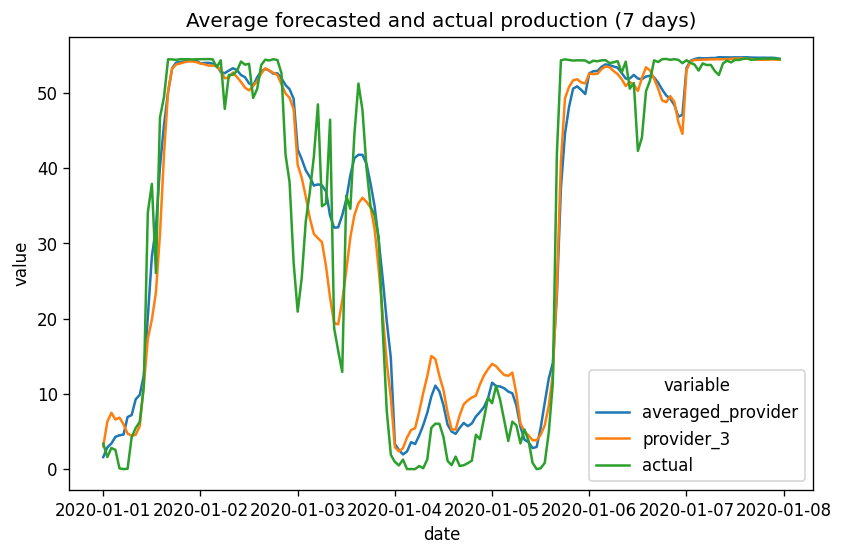

In [14]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "averaged_provider": average_provider[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Average forecasted and actual production (7 days)")



### Comparing the quality of the four forecasts

In [19]:
def compare_forecasts(list_of_forecasts, actual):

  for forecast in list_of_forecasts:

    print('RMSE of {forecast} is {rmse}'.format(forecast = 'forecast', rmse = ((forecast[:168].power - actual[:168].power) ** 2).mean() ** 0.5))

In [20]:
compare_forecasts([provider_1, provider_2, provider_3, average_provider], actual_generation)

RMSE of forecast is 6.935762520415258
RMSE of forecast is 6.5225388737236
RMSE of forecast is 6.3139926987165484
RMSE of forecast is 5.807227581587172


### Split train/valid/test

In [21]:
train_idx = np.arange(12336)
valid_idx = np.arange(12336, 12504)
test_idx = np.arange(12504, 12528)